## Загрузим нужные библиотеки

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

%matplotlib inline

In [4]:
DATA_DIR = "data/"

In [115]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    tmp = df[sorted(df.columns, key=lambda x: tuple(x.split("_")))]
    min_idx = None
    tmp.loc[:, tmp.columns.str.contains("nd_mean_")] = tmp.loc[:, tmp.columns.str.contains(
        "nd_mean_")].replace(0, np.nan)
    for i, col in enumerate(tmp):
        if col.startswith("nd_mean_"):
            if min_idx is None:
                min_idx = i
                tmp.iloc[:, i] = tmp.iloc[:, i].fillna(tmp.iloc[:, i + 1].mean())
            else:
                tmp.iloc[:, i] = tmp.iloc[:, i].fillna(tmp.iloc[:, i - 1:i + 2:2].mean(axis=1))
    return tmp.set_index("id")

In [350]:
import geopandas as gpd
from shapely.geometry import shape
import json


def df_to_gdf(df):
    gdf = gpd.GeoDataFrame(df.drop([".geo"], axis=1))
    gdf["geometry"] = df[".geo"].apply(lambda x: shape(json.loads(x)))
    # gdf["center_X"] = gdf.geometry.centroid.x
    # gdf["center_Y"] = gdf.geometry.centroid.y
    return gdf


In [342]:
regions = gpd.read_file(DATA_DIR + "boundaries/admin_level_4.shp")

In [344]:
regions = regions[["name_en", "geometry"]]

In [345]:
regions

,name_en,geometry
0,None,"POLYGON ((35.39847 50.90907, 35.39812 50.90910..."
1,Kamchatka Krai,"MULTIPOLYGON (((168.44560 54.51135, 168.44581 ..."
2,Murmansk Oblast,"POLYGON ((42.50570 66.99024, 42.31571 66.86190..."
3,Perm Krai,"POLYGON ((59.48273 60.82788, 59.47942 60.82226..."
4,Sverdlovsk Oblast,"POLYGON ((66.18486 58.01097, 66.18442 58.01063..."
...,...,...
83,Krasnoyarsk Krai,"MULTIPOLYGON (((88.65810 55.29358, 88.65829 55..."
84,Buryatia,"POLYGON ((116.92138 54.79902, 116.92056 54.796..."
85,Irkutsk Oblast,"POLYGON ((119.13931 58.29523, 119.13898 58.294..."
86,Kabardino-Balkaria,"POLYGON ((44.47537 43.58294, 44.44452 43.54272..."


In [371]:
def add_region(df):
    df["region"] = df.apply(lambda row: regions.loc[regions.geometry.contains(row["geometry"].centroid), "name_en"].ravel()[0], axis=1)

In [375]:
train_df = df_to_gdf(preprocess(pd.read_csv(DATA_DIR + "train.csv")))
test_df = df_to_gdf(preprocess(pd.read_csv(DATA_DIR + "test.csv")))

In [376]:
add_region(train_df)
add_region(test_df)

In [378]:
train_df["region"].value_counts()

Voronezh Oblast           1256
Tatarstan                  804
Bryansk Oblast             726
Bashkortostan              687
Nizhny Novgorod Oblast     318
Tula Oblast                317
Oryol Oblast               255
Ryazan Oblast              165
Lipetsk Oblast             152
Sverdlovsk Oblast          113
Perm Krai                   40
Moscow Oblast               29
Kaluga Oblast               25
Chelyabinsk Oblast          11
Name: region, dtype: int64

In [379]:
test_df["region"].value_counts()

Voronezh Oblast           520
Tatarstan                 365
Bryansk Oblast            326
Bashkortostan             304
Nizhny Novgorod Oblast    135
Tula Oblast               135
Oryol Oblast              118
Ryazan Oblast              69
Lipetsk Oblast             51
Sverdlovsk Oblast          37
Moscow Oblast              19
Perm Krai                  11
Kaluga Oblast               6
Chelyabinsk Oblast          4
Name: region, dtype: int64

In [380]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_df["region"])

def encode_region(df):
    df["region"] = le.transform(df["region"])

le.classes_

array(['Bashkortostan', 'Bryansk Oblast', 'Chelyabinsk Oblast',
       'Kaluga Oblast', 'Lipetsk Oblast', 'Moscow Oblast',
       'Nizhny Novgorod Oblast', 'Oryol Oblast', 'Perm Krai',
       'Ryazan Oblast', 'Sverdlovsk Oblast', 'Tatarstan', 'Tula Oblast',
       'Voronezh Oblast'], dtype=object)

In [381]:
encode_region(train_df)
encode_region(test_df)

In [382]:
train_df.head()

,area,crop,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-19,nd_mean_2021-04-20,nd_mean_2021-04-22,nd_mean_2021-04-23,nd_mean_2021-04-25,...,nd_mean_2021-08-01,nd_mean_2021-08-07,nd_mean_2021-08-10,nd_mean_2021-08-11,nd_mean_2021-08-12,nd_mean_2021-08-13,nd_mean_2021-08-23,nd_mean_2021-08-27,geometry,region
id,,,,,,,,,,,,,,,,,,,,,
1612,40,5,0.159413,0.251090,0.288860,0.019123,0.280155,0.039673,0.557330,0.429630,...,0.222381,0.066429,0.380075,0.438667,0.419654,0.413159,0.360077,0.360077,"POLYGON ((49.33090 56.21618, 49.33131 56.21605...",11
978,75,0,0.231795,0.260749,0.304190,0.386073,0.434587,0.483102,0.037334,0.125499,...,0.697440,0.724046,0.271984,0.306741,0.674723,0.339988,0.242724,0.145459,"POLYGON ((41.41193 51.19045, 41.41194 51.19035...",13
3050,75,6,0.219785,0.176574,0.226500,0.276425,0.284121,0.291817,0.209893,0.191213,...,0.633516,0.526461,0.419407,0.168108,0.566099,0.306182,0.046266,0.023593,"POLYGON ((40.88636 50.47753, 40.88640 50.47742...",13
4960,55,1,0.219785,0.317001,0.267246,0.042987,0.042987,0.079031,0.115075,0.191046,...,0.036621,0.072939,0.018503,0.116995,0.232878,0.588483,0.807123,0.020564,"POLYGON ((33.86368 53.27593, 33.86488 53.27714...",1
2548,25,6,0.083827,0.125415,0.167003,0.248698,0.120483,0.308370,0.173496,0.038622,...,0.268191,0.411369,0.068211,0.347887,0.422165,0.143457,0.379317,0.215363,"POLYGON ((56.31368 54.39526, 56.31372 54.39517...",0


<AxesSubplot: >

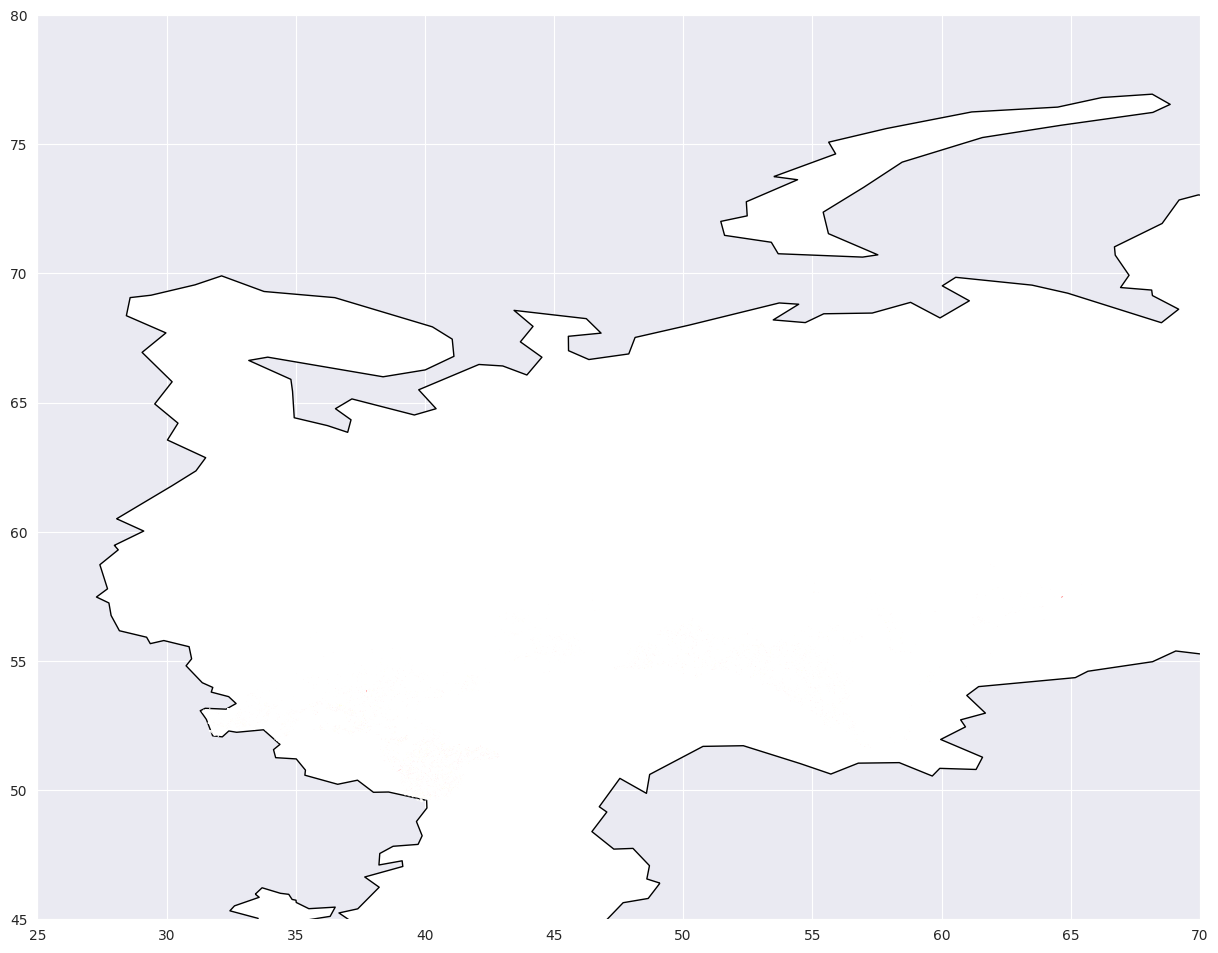

In [383]:
plt.rcParams['figure.figsize'] = (15, 15)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world[world.iso_a3 == 'RUS'].plot(color='white', edgecolor='black')
ax.set_xlim(25, 70)
ax.set_ylim(45, 80)
train_df.plot(ax=ax, color='red')
test_df.plot(ax=ax, color='yellow')

<AxesSubplot: >

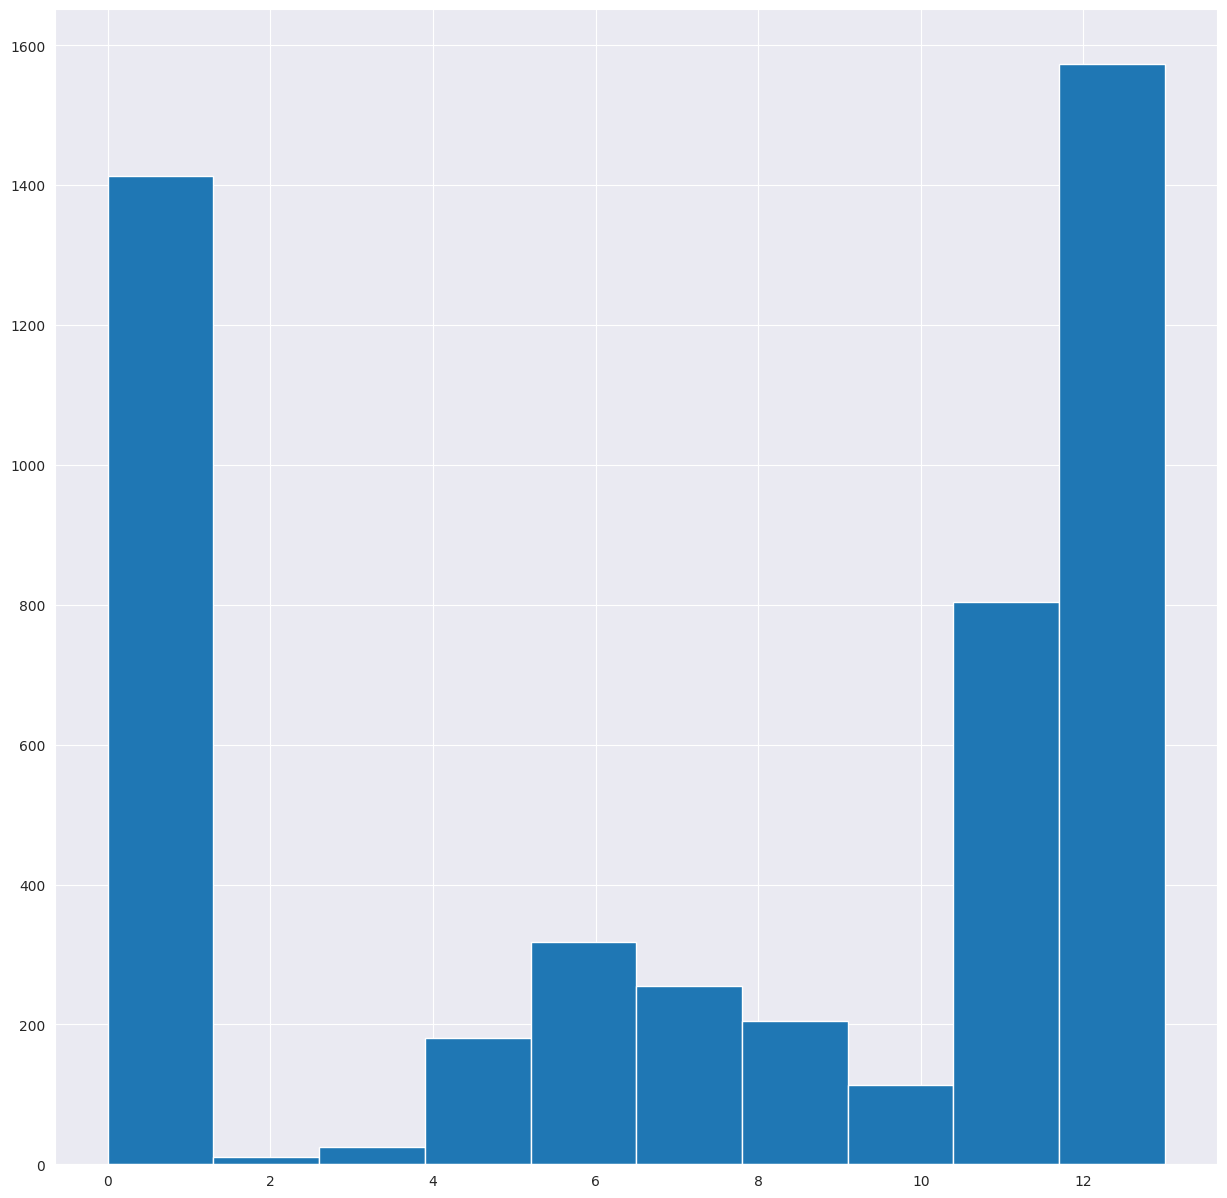

In [384]:
train_df["region"].hist()

<AxesSubplot: >

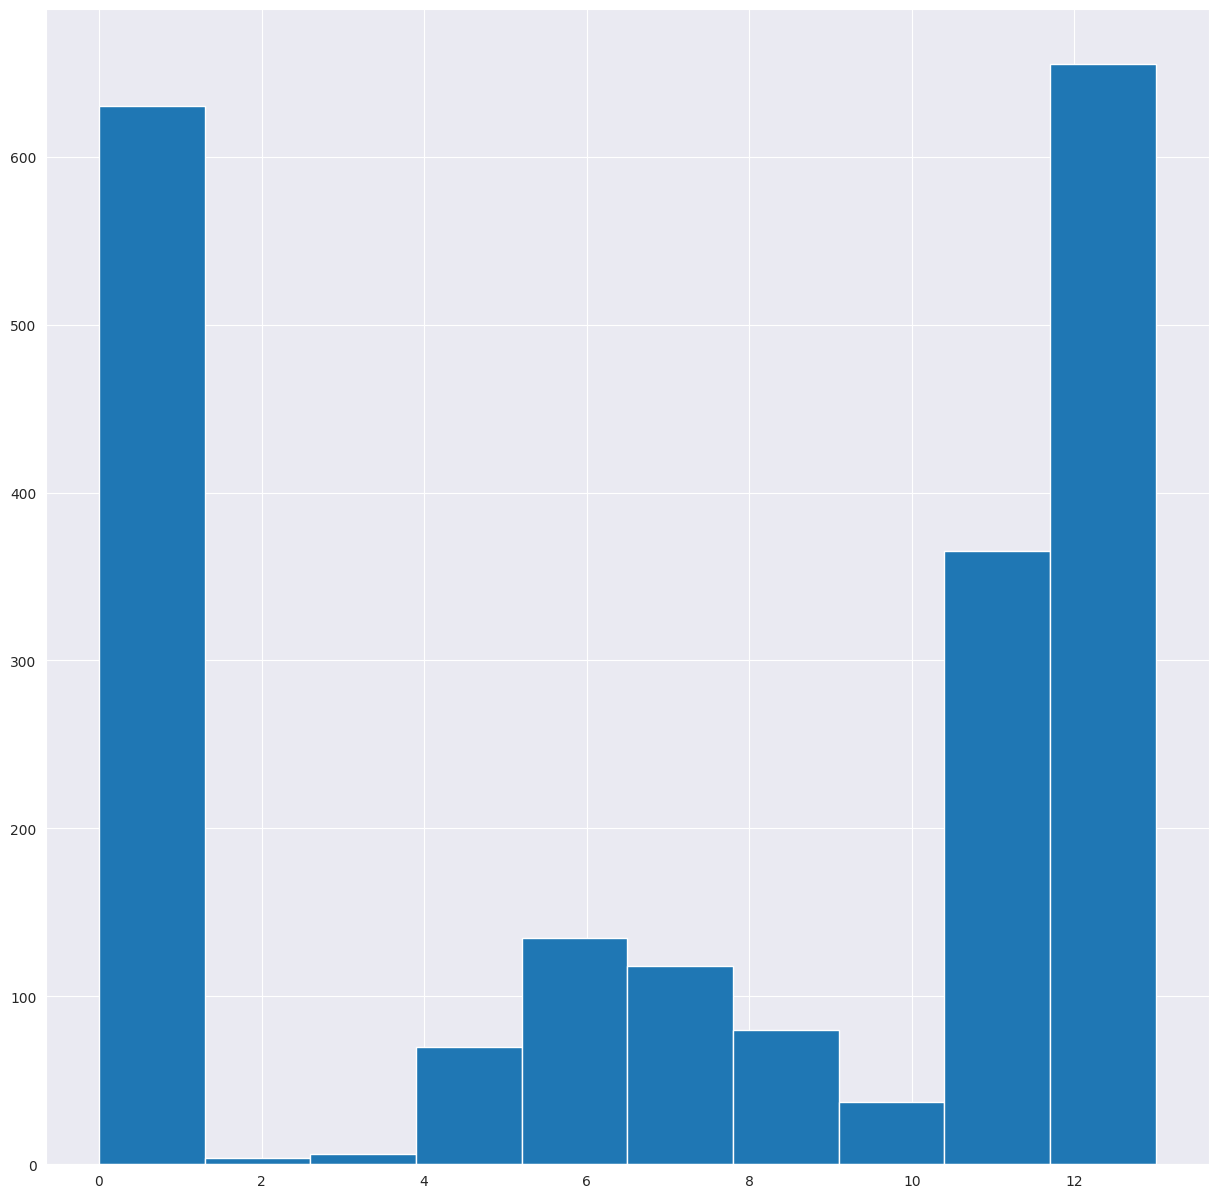

In [385]:
test_df["region"].hist()

Теперь рассмотрим главный столбец с C/Х культурой

<AxesSubplot: >

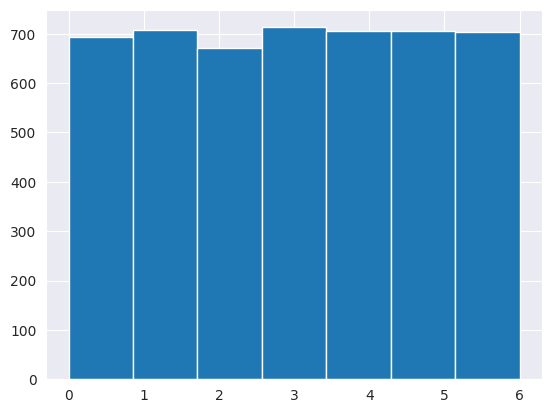

In [98]:
train_df["crop"].hist(bins=7)

Заметен слабый разброс популярности категорий

In [526]:
train_df["crop"].value_counts()

3    713
1    707
5    706
4    705
6    703
0    693
2    671
Name: crop, dtype: int64

Посмотрим на разброс площади полей

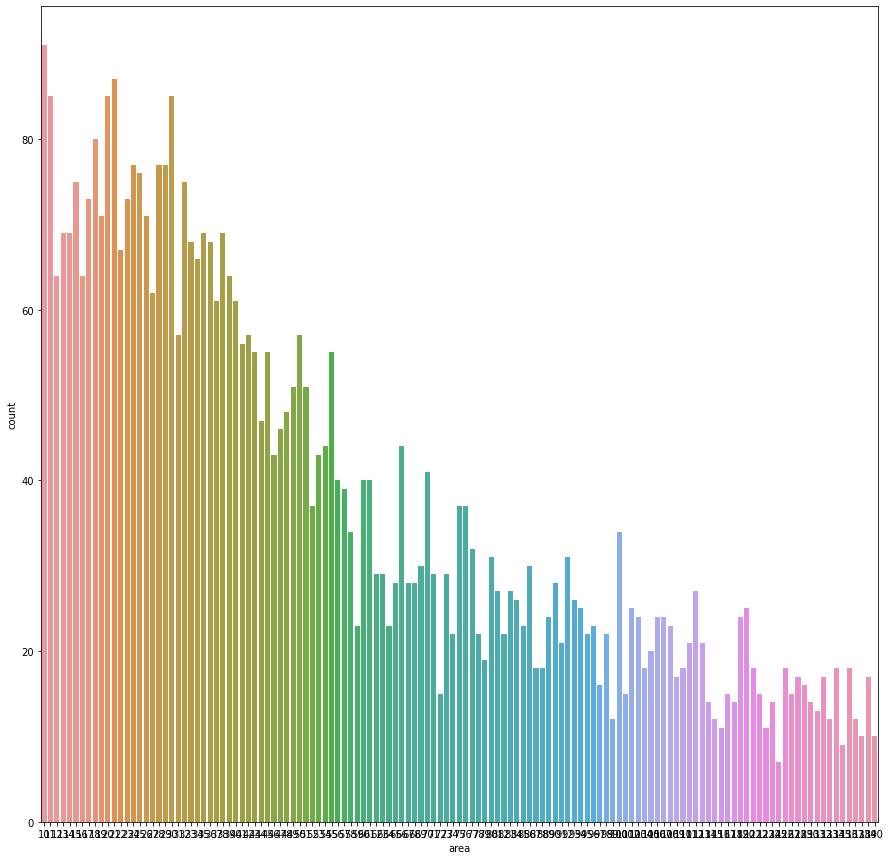

In [527]:
sns.countplot(x="area", data=train_df)

Последняя попытка найти явную зависимость в данных

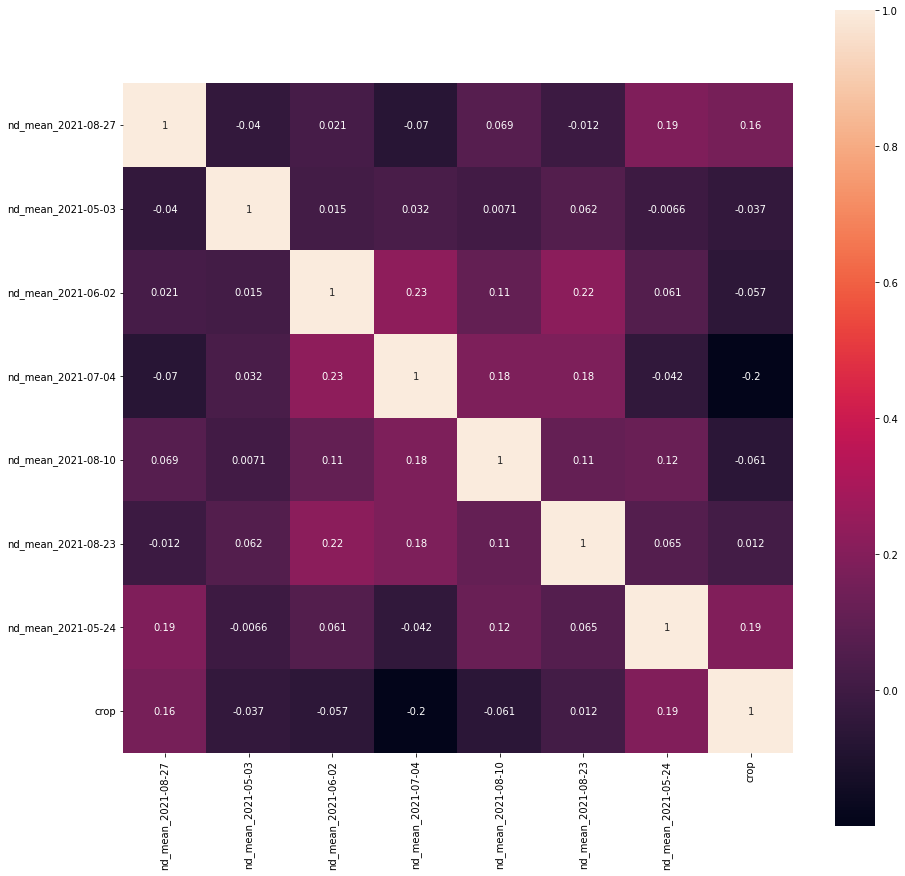

In [529]:
plt.rcParams['figure.figsize'] = (15, 15)

corr = train_df.loc[:, "nd_mean_2021-08-27":"crop"].corr()
g = sns.heatmap(corr, square=True, annot=True)

## Выделим выборки

In [386]:
def drop_unused_cols(df):
    return df.drop(["area", "geometry"], axis=1)

In [387]:
X = drop_unused_cols(train_df).drop(["crop"], axis=1)
y = train_df.crop.ravel()

In [388]:
X.head()

,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-19,nd_mean_2021-04-20,nd_mean_2021-04-22,nd_mean_2021-04-23,nd_mean_2021-04-25,nd_mean_2021-04-26,nd_mean_2021-04-27,...,nd_mean_2021-07-31,nd_mean_2021-08-01,nd_mean_2021-08-07,nd_mean_2021-08-10,nd_mean_2021-08-11,nd_mean_2021-08-12,nd_mean_2021-08-13,nd_mean_2021-08-23,nd_mean_2021-08-27,region
id,,,,,,,,,,,,,,,,,,,,,
1612,0.159413,0.251090,0.288860,0.019123,0.280155,0.039673,0.557330,0.429630,0.301931,0.243815,...,0.253709,0.222381,0.066429,0.380075,0.438667,0.419654,0.413159,0.360077,0.360077,11
978,0.231795,0.260749,0.304190,0.386073,0.434587,0.483102,0.037334,0.125499,0.213664,0.358012,...,0.742016,0.697440,0.724046,0.271984,0.306741,0.674723,0.339988,0.242724,0.145459,13
3050,0.219785,0.176574,0.226500,0.276425,0.284121,0.291817,0.209893,0.191213,0.352851,0.214349,...,0.619111,0.633516,0.526461,0.419407,0.168108,0.566099,0.306182,0.046266,0.023593,13
4960,0.219785,0.317001,0.267246,0.042987,0.042987,0.079031,0.115075,0.191046,0.265689,0.151877,...,0.784641,0.036621,0.072939,0.018503,0.116995,0.232878,0.588483,0.807123,0.020564,1
2548,0.083827,0.125415,0.167003,0.248698,0.120483,0.308370,0.173496,0.038622,0.150439,0.007706,...,0.467074,0.268191,0.411369,0.068211,0.347887,0.422165,0.143457,0.379317,0.215363,0


## Обучение модели

In [433]:
from sklearn.svm import SVC
from sklearn.metrics import recall_score

In [420]:
from sklearn.neighbors import KNeighborsClassifier

In [389]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [435]:
X_submission = drop_unused_cols(test_df)

In [436]:
all_preds = X_test.copy()
all_preds["crop"] = 0

submission_preds = X_submission.copy()
submission_preds["crop"] = 0

for i, reg in enumerate(le.classes_):
    print(reg)
    clf = SVC(random_state=42, decision_function_shape='ovr', break_ties=True, **{'C': 10000, 'kernel': 'rbf'})
    # clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=6, weights='distance')
    clf.fit(X_train[X_train.region == i], y_train[X_train.region == i])
    flt = X_train.region == i
    print('Samples:', len(X_train[flt]))
    pred = clf.predict(X_train[flt])
    print('Train:', recall_score(y_train[flt], pred, average="macro", zero_division=0) * 100)
    flt = X_test.region == i
    pred = clf.predict(X_test[flt])
    all_preds.loc[all_preds.region == i, "crop"] = pred
    print('Test:', recall_score(y_test[flt], pred, average="macro", zero_division=0) * 100)

    flt = X_submission.region == i
    pred = clf.predict(X_submission[flt])
    submission_preds.loc[flt, "crop"] = pred
    print()

print('Test total:', recall_score(y_test, all_preds["crop"].ravel(), average="macro", zero_division=0) * 100)
submission_df = submission_preds[["crop"]]

Bashkortostan
Samples: 484
Train: 100.0
Test: 88.8812002533807

Bryansk Oblast
Samples: 506
Train: 100.0
Test: 69.68268472437519

Chelyabinsk Oblast
Samples: 8
Train: 100.0
Test: 50.0

Kaluga Oblast
Samples: 15
Train: 100.0
Test: 66.66666666666666

Lipetsk Oblast
Samples: 111
Train: 100.0
Test: 45.831932773109244

Moscow Oblast
Samples: 20
Train: 100.0
Test: 50.0

Nizhny Novgorod Oblast
Samples: 226
Train: 100.0
Test: 63.13686313686314

Oryol Oblast
Samples: 187
Train: 100.0
Test: 66.55844155844156

Perm Krai
Samples: 25
Train: 100.0
Test: 91.66666666666666

Ryazan Oblast
Samples: 112
Train: 100.0
Test: 79.16666666666666

Sverdlovsk Oblast
Samples: 86
Train: 100.0
Test: 50.0

Tatarstan
Samples: 557
Train: 100.0
Test: 92.23213250041906

Tula Oblast
Samples: 221
Train: 100.0
Test: 77.47252747252747

Voronezh Oblast
Samples: 870
Train: 98.83697229257392
Test: 75.81390620764435

Test total: 83.18924476660277


In [ ]:
from sklearn.model_selection import KFold, cross_val_score

kfold = KFold(n_splits=10)

In [390]:
# clf = RandomForestClassifier(random_state=0, n_estimators=1000, n_jobs=-1)

# clf = NuSVC(kernel='rbf', random_state=42, decision_function_shape='ovr', nu=0.35, break_ties=True)
clf = SVC(random_state=42, decision_function_shape='ovr', break_ties=True, **{'C': 10000, 'gamma': 1e-05, 'kernel': 'rbf'})

In [391]:
cross_val_score(clf, X_train, y_train, cv=kfold, verbose=1, n_jobs=-1, scoring='recall_macro')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.7s finished


array([0.79685828, 0.83179839, 0.78421175, 0.80784189, 0.78435261,
       0.82087784, 0.82161073, 0.7696559 , 0.80557707, 0.80933792])

In [341]:
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV
#
# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
#                      'C': [0.1, 10, 25, 50, 100, 1000, 10_000]},
#                     {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
#                      'C': [0.1, 10, 25, 50, 100, 1000, 10_000]},
#                     {'kernel': ['linear'], 'C': [0.1, 1, 5, 10, 50, 100, 500]},
#                     {'kernel': ['poly'], 'C': [0.1, 10, 25, 50, 100, 1000, 10_000], 'degree': [1, 2, 3, 4, 5]}
#                     ]
#
# clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,
#                    scoring='recall_macro', verbose=3)
# clf.fit(X_train, y_train)
#
# print("Best parameters set found on development set:")
# print()
# print(clf.best_params_)
# print()
# print("Grid scores on development set:")
# print()
# means = clf.cv_results_['mean_test_score']
# stds = clf.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#           % (mean, std * 2, params))

Fitting 5 folds for each of 98 candidates, totalling 490 fits
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.298 total time=   0.7s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.280 total time=   0.6s
[CV 3/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.286 total time=   0.6s
[CV 4/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.297 total time=   0.6s
[CV 5/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.290 total time=   0.6s
[CV 1/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.244 total time=   0.6s
[CV 2/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.262 total time=   0.6s
[CV 3/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.235 total time=   0.6s
[CV 4/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.251 total time=   0.6s
[CV 5/5] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.231 total time=   0.6s
[CV 1/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.216 total time=   0.6s
[CV 2/5] END ...C=0.1, gamma=0.0001, kernel=rbf

In [392]:
clf.fit(X_train, y_train)

SVC(C=10000, break_ties=True, gamma=1e-05, random_state=42)

## Оценка точности

In [393]:
pred = clf.predict(X_test)
print(clf, '\n', recall_score(y_test, pred, average="macro", zero_division=0) * 100)

SVC(C=10000, break_ties=True, gamma=1e-05, random_state=42) 
 79.81010214482787


In [394]:
X_submission = drop_unused_cols(test_df)

In [395]:
X_submission.head()

,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-19,nd_mean_2021-04-20,nd_mean_2021-04-22,nd_mean_2021-04-23,nd_mean_2021-04-25,nd_mean_2021-04-26,nd_mean_2021-04-27,...,nd_mean_2021-07-31,nd_mean_2021-08-01,nd_mean_2021-08-07,nd_mean_2021-08-10,nd_mean_2021-08-11,nd_mean_2021-08-12,nd_mean_2021-08-13,nd_mean_2021-08-23,nd_mean_2021-08-27,region
id,,,,,,,,,,,,,,,,,,,,,
3961,0.570259,0.311567,0.158459,0.030764,0.449325,0.487931,0.526537,0.468491,0.410445,0.122400,...,0.406522,0.205785,0.112872,0.095615,0.329089,0.193055,0.508451,0.491184,0.473916,13
811,0.099120,0.120262,0.058465,0.388645,0.193263,0.512710,0.046584,0.247342,0.498558,0.357397,...,0.496499,0.016250,0.151031,0.285811,0.093282,0.760639,0.424868,0.089097,0.491863,1
2471,0.284628,0.270622,0.306984,0.258549,0.285254,0.358121,0.267468,0.069721,0.171494,0.127101,...,0.311765,0.131007,0.240145,0.325201,0.410257,0.391575,0.381593,0.358071,0.334549,0
3950,0.223029,0.134871,0.031266,0.123050,0.097313,0.071576,0.480065,0.064341,0.265254,0.235859,...,0.262506,0.136903,0.011300,0.192649,0.225841,0.379371,0.260400,0.039076,0.039076,13
414,0.274234,0.247413,0.334272,0.178496,0.300357,0.135544,0.481930,0.269764,0.053176,0.490588,...,0.040426,0.292561,0.579184,0.567705,0.556226,0.540012,0.307260,0.074508,0.086551,11


In [396]:
y_submission = clf.predict(X_submission)

In [397]:
y_submission

array([3, 2, 3, ..., 3, 6, 6])

In [400]:
submission_df = test_df.copy()

In [401]:
submission_df["crop"] = y_submission
submission_df = submission_df[["crop"]]
submission_df

,crop
id,
3961,3
811,2
2471,3
3950,5
414,4
...,...
5201,2
5465,1
6640,3


In [437]:
submission_df.to_csv(DATA_DIR + "submission.csv")

<AxesSubplot: >

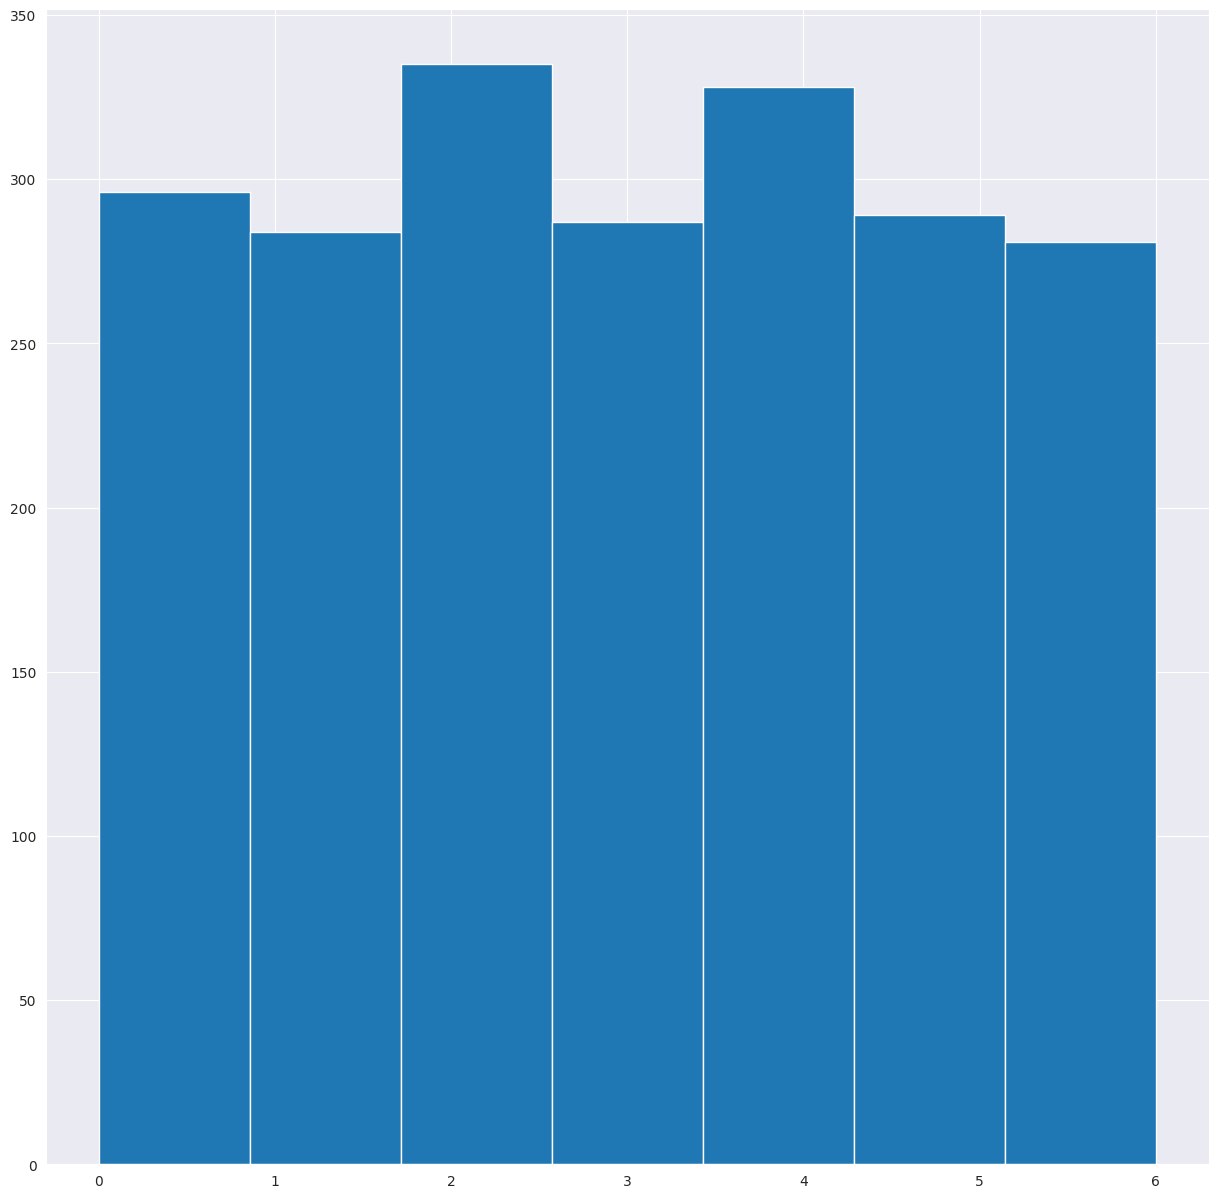

In [438]:
submission_df["crop"].hist(bins=7)

In [398]:
train_df.to_csv(DATA_DIR + "train_with_reg.csv")

In [399]:
test_df.to_csv(DATA_DIR + "test_with_reg.csv")